In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Dataset : Person segmentation
link: https://www.kaggle.com/datasets/nikhilroxtomar/person-segmentation/data

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/kaggle'

In [ ]:
!kaggle datasets download -d nikhilroxtomar/person-segmentation

 98% 454M/461M [00:03<00:00, 218MB/s]
100% 461M/461M [00:03<00:00, 156MB/s]


In [ ]:
import zipfile

file_path = '/content/person-segmentation.zip'

with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/person-segmentation/')

# Import Libraries

In [ ]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.layers import AveragePooling2D, GlobalAveragePooling2D, UpSampling2D, Reshape, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import tensorflow as tf

In [ ]:
import cv2
import pandas as pd
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from glob import glob
from sklearn.model_selection import train_test_split

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard

In [31]:
from tqdm import tqdm
import urllib
import IPython

Define global Variables

In [ ]:
H,W=256,256

# Define Model

In [ ]:
def support(img_feat):
  shape=img_feat.shape
  y1 = AveragePooling2D(pool_size=(shape[1], shape[2]))(img_feat)
  y1 = Conv2D(256, 1, padding="same", use_bias=False)(y1)
  y1 = BatchNormalization()(y1)
  y1 = Activation("relu")(y1)
  y1 = UpSampling2D((8,8), interpolation="bilinear")(y1)

  y2 = Conv2D(256,1,padding="same")(img_feat)
  y2 = MaxPool2D(2,strides=2)(y2)
  y2 = BatchNormalization()(y2)
  y2 = Activation("relu")(y2)


  y3 = Conv2D(256,3,padding="same",dilation_rate=2)(img_feat)
  y3 = MaxPool2D(2,strides=2)(y3)
  y3 = BatchNormalization()(y3)
  y3 = Activation("relu")(y3)

  y4 = Conv2D(256,3,padding="same",dilation_rate=4)(img_feat)
  y4 = MaxPool2D(2,strides=2)(y4)
  y4 = BatchNormalization()(y4)
  y4 = Activation("relu")(y4)

  y5 = Conv2D(256,3,padding="same",dilation_rate=8)(img_feat)
  y5 = MaxPool2D(2,strides=2)(y5)
  y5 = BatchNormalization()(y5)
  y5 = Activation("relu")(y5)

  y = Concatenate()([ y1,y2, y3, y4, y5])
  y = Conv2D(256, 1, padding="same", use_bias=False)(y)
  y = BatchNormalization()(y)
  y = Activation("relu")(y)

  return y

In [ ]:
def define_model(shape):
  inp=Input(shape)

  encd= ResNet50(weights="imagenet", include_top=False, input_tensor=inp)

  img_feat=encd.get_layer("conv4_block6_out").output

  y=support(img_feat)
  y=UpSampling2D((2, 2), interpolation="bilinear")(y)

  a = encd.get_layer("conv4_block4_out").output
  a = Conv2D(filters=48, kernel_size=1, padding='same', use_bias=False)(a)
  a = BatchNormalization()(a)
  a = Activation("relu")(a)

  i = Concatenate()([y,a])


  se = GlobalAveragePooling2D()(i)
  se = Reshape((1, 1, i.shape[-1]))(se)
  se = Dense(i.shape[-1] // 8, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
  se = Dense(i.shape[-1], activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)
  x = i * se

  x = Conv2D(filters=256, kernel_size=3, padding='same', use_bias=False)(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(filters=256, kernel_size=3, padding='same', use_bias=False)(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  se1 = GlobalAveragePooling2D()(x)
  se1 = Reshape((1, 1, x.shape[-1]))(se1)
  se1 = Dense(x.shape[-1] // 8, activation='relu', kernel_initializer='he_normal', use_bias=False)(se1)
  se1 = Dense(x.shape[-1], activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se1)
  l = x * se1

  l = UpSampling2D((16, 16), interpolation="bilinear")(l)
  l = Conv2D(1, 1)(l)
  l = Activation("sigmoid")(l)

  model = Model(inp, l)
  return model

# Load and preprocess Data

In [ ]:
def load_data(dataset_path):
    images = sorted(glob(os.path.join(dataset_path, "images/*")))
    masks = sorted(glob(os.path.join(dataset_path, "masks/*")))
    train_x, test_x = train_test_split(images, test_size=0.2, random_state=42)
    train_y, test_y = train_test_split(masks, test_size=0.2, random_state=42)
    return (train_x, train_y), (test_x, test_y)
def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (256, 256))
    x = x/255.0
    x = x.astype(np.float32)
    return x
def read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (256, 256))
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=-1)
    return x
def preprocess(image_path, mask_path):
    def f(image_path, mask_path):
        image_path = image_path.decode()
        mask_path = mask_path.decode()
        x = read_image(image_path)
        y = read_mask(mask_path)
        return x, y
    image, mask = tf.numpy_function(f, [image_path, mask_path], [tf.float32, tf.float32])
    image.set_shape([256, 256, 3])
    mask.set_shape([256, 256, 1])
    return image, mask
def tf_dataset(images, masks, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((images, masks))
    dataset = dataset.shuffle(buffer_size=5000)
    dataset = dataset.map(preprocess)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(2)
    return dataset

In [ ]:
dataset_path = "/content/person-segmentation/people_segmentation"
input_shape = (256, 256, 3)
batch_size = 8

# Create Dataset

In [ ]:
(train_x, train_y), (test_x, test_y) = load_data(dataset_path)

train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
valid_dataset = tf_dataset(test_x, test_y, batch=batch_size)

#Train Dataset

In [ ]:
model=define_model((H,W,3))

94765736/94765736 [==============================] - 1s 0us/step


In [30]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [ ]:
model_path = "./model.h5"
csv_path = "./data.csv"
epochs = 30
lr = 1e-4

In [ ]:
model.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(lr),
    metrics=[
        tf.keras.metrics.MeanIoU(num_classes=2),
        tf.keras.metrics.Recall(),
        tf.keras.metrics.Precision()
    ]
)

callbacks = [
    ModelCheckpoint(model_path, monitor="val_loss", verbose=1),
    ReduceLROnPlateau(monitor="val_loss", patience=5, factor=0.1, verbose=1),
    CSVLogger(csv_path),
    EarlyStopping(monitor="val_loss", patience=5)
]
train_steps = len(train_x)//batch_size
if len(train_x) % batch_size != 0:
    train_steps += 1

valid_steps = len(test_x)//batch_size
if len(test_x) % batch_size != 0:
    valid_steps += 1

model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs = epochs,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    callbacks=callbacks
)

Epoch 1/30
568/568 [==============================] - ETA: 0s - loss: 0.1203 - mean_io_u_1: 0.3722 - recall_1: 0.9107 - precision_1: 0.9067
Epoch 1: saving model to ./model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


568/568 [==============================] - 142s 199ms/step - loss: 0.1203 - mean_io_u_1: 0.3722 - recall_1: 0.9107 - precision_1: 0.9067 - val_loss: 0.1622 - val_mean_io_u_1: 0.3721 - val_recall_1: 0.8649 - val_precision_1: 0.8887 - lr: 1.0000e-04
Epoch 2/30
568/568 [==============================] - ETA: 0s - loss: 0.0869 - mean_io_u_1: 0.3723 - recall_1: 0.9362 - precision_1: 0.9314
Epoch 2: saving model to ./model.h5
568/568 [==============================] - 109s 191ms/step - loss: 0.0869 - mean_io_u_1: 0.3723 - recall_1: 0.9362 - precision_1: 0.9314 - val_loss: 0.1152 - val_mean_io_u_1: 0.3721 - val_recall_1: 0.9036 - val_precision_1: 0.9250 - lr: 1.0000e-04
Epoch 3/30
568/568 [==============================] - ETA: 0s - loss: 0.0743 - mean_io_u_1: 0.3725 - recall_1: 0.9455 - precision_1: 0.9400
Epoch 3: saving model to ./model.h5
568/568 [==============================] - 113s 200ms/step - loss: 0.0743 - mean_io_u_1: 0.3725 - recall_1: 0.9455 - precision_1: 0.9400 - val_loss: 0.1

# Test Model

In [32]:

test_images = [
    'https://raw.githubusercontent.com/nikhilroxtomar/Unet-for-Person-Segmentation/main/images/Black-Widow-Avengers.jpg'
]

model = tf.keras.models.load_model("./model.h5")
for path in tqdm(test_images, total=len(test_images)):

    req = urllib.request.urlopen(path)
    imgarr = np.asarray(bytearray(req.read()), dtype=np.uint8)

    x = cv2.imdecode(imgarr, -1)

    original_image = x
    h, w, _ = x.shape

    x = cv2.resize(x, (256, 256))
    x = x/255.0
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=0)

    pred_mask = model.predict(x)[0]
    pred_mask = cv2.resize(pred_mask, (w, h))
    pred_mask = np.expand_dims(pred_mask, axis=-1)
    pred_mask = pred_mask > 0.5

    background_mask = np.abs(1- pred_mask)

    masked_image = original_image * pred_mask

    background_mask = np.concatenate([background_mask, background_mask, background_mask], axis=-1)
    background_mask = background_mask * [0, 0, 0]

    masked_image = masked_image + background_mask
    name = path.split("/")[-1]
    cv2.imwrite(f"{name}.png", masked_image)

  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step


100%|██████████| 1/1 [00:02<00:00,  2.62s/it]


In [49]:
x=original_image
x = cv2.resize(x, (256, 256))
x = x/255.0
x = x.astype(np.float32)
# x = np.expand_dims(x, axis=-1)

Input Image

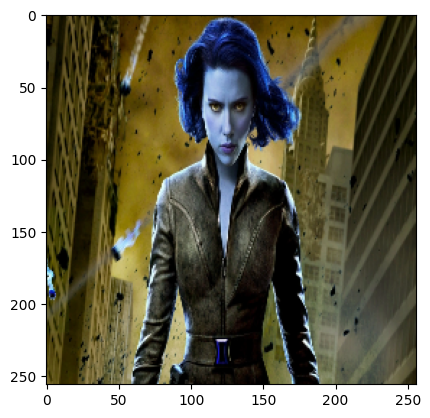

In [51]:
plt.imshow(x,vmax=256)
plt.show()

Output Image (without bg)

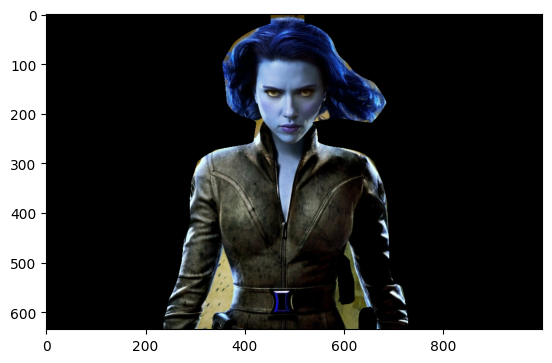

In [39]:
img="/content/Black-Widow-Avengers.jpg.png"
img=cv2.imread(img,cv2.IMREAD_COLOR)
plt.imshow(img,vmax=256)
plt.show()